In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

ModuleNotFoundError: No module named 'keras'

In [4]:
df=pd.read_csv(r'C:\Users\Lenovo\Documents\Twitter_Data sentiment anlaysis.csv')
df.head(10)

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
5           kiya tho refresh maarkefir comment karo        0.0
6  surat women perform yagna seeks divine grace f...       0.0
7  this comes from cabinet which has scholars lik...       0.0
8  with upcoming election india saga going import...       1.0
9                         gandhi was gay does modi         1.0

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [36]:
df.category.unique()

array([-1.,  0.,  1., nan])

In [37]:
df.describe()

category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

In [38]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [39]:
df.columns

Index(['clean_text', 'category'], dtype='object')

In [6]:
df[df['category'].isna()]

clean_text  category
130448  the foundation stone northeast gas grid inaugu...       NaN
155642  dear terrorists you can run but you cant hide ...       NaN
155698  offense the best defence with mission shakti m...       NaN
155770  have always heard politicians backing out thei...       NaN
158693  modi government plans felicitate the faceless ...       NaN
159442               chidambaram gives praises modinomics       NaN
160559  the reason why modi contested from seats 2014 ...       NaN

In [7]:
df[df['clean_text'].isna()]

clean_text  category
148           NaN       0.0
158694        NaN      -1.0
159443        NaN       0.0
160560        NaN       1.0

In [56]:
clean_df=df.drop(df[df['clean_text'].isna()].index, inplace=True)
cat_df=df.drop(df[df['category'].isna()].index, inplace=True)

In [47]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [48]:
def message_text_process(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() 
            not in stopwords.words('english')]

In [13]:
##Analysing the data 

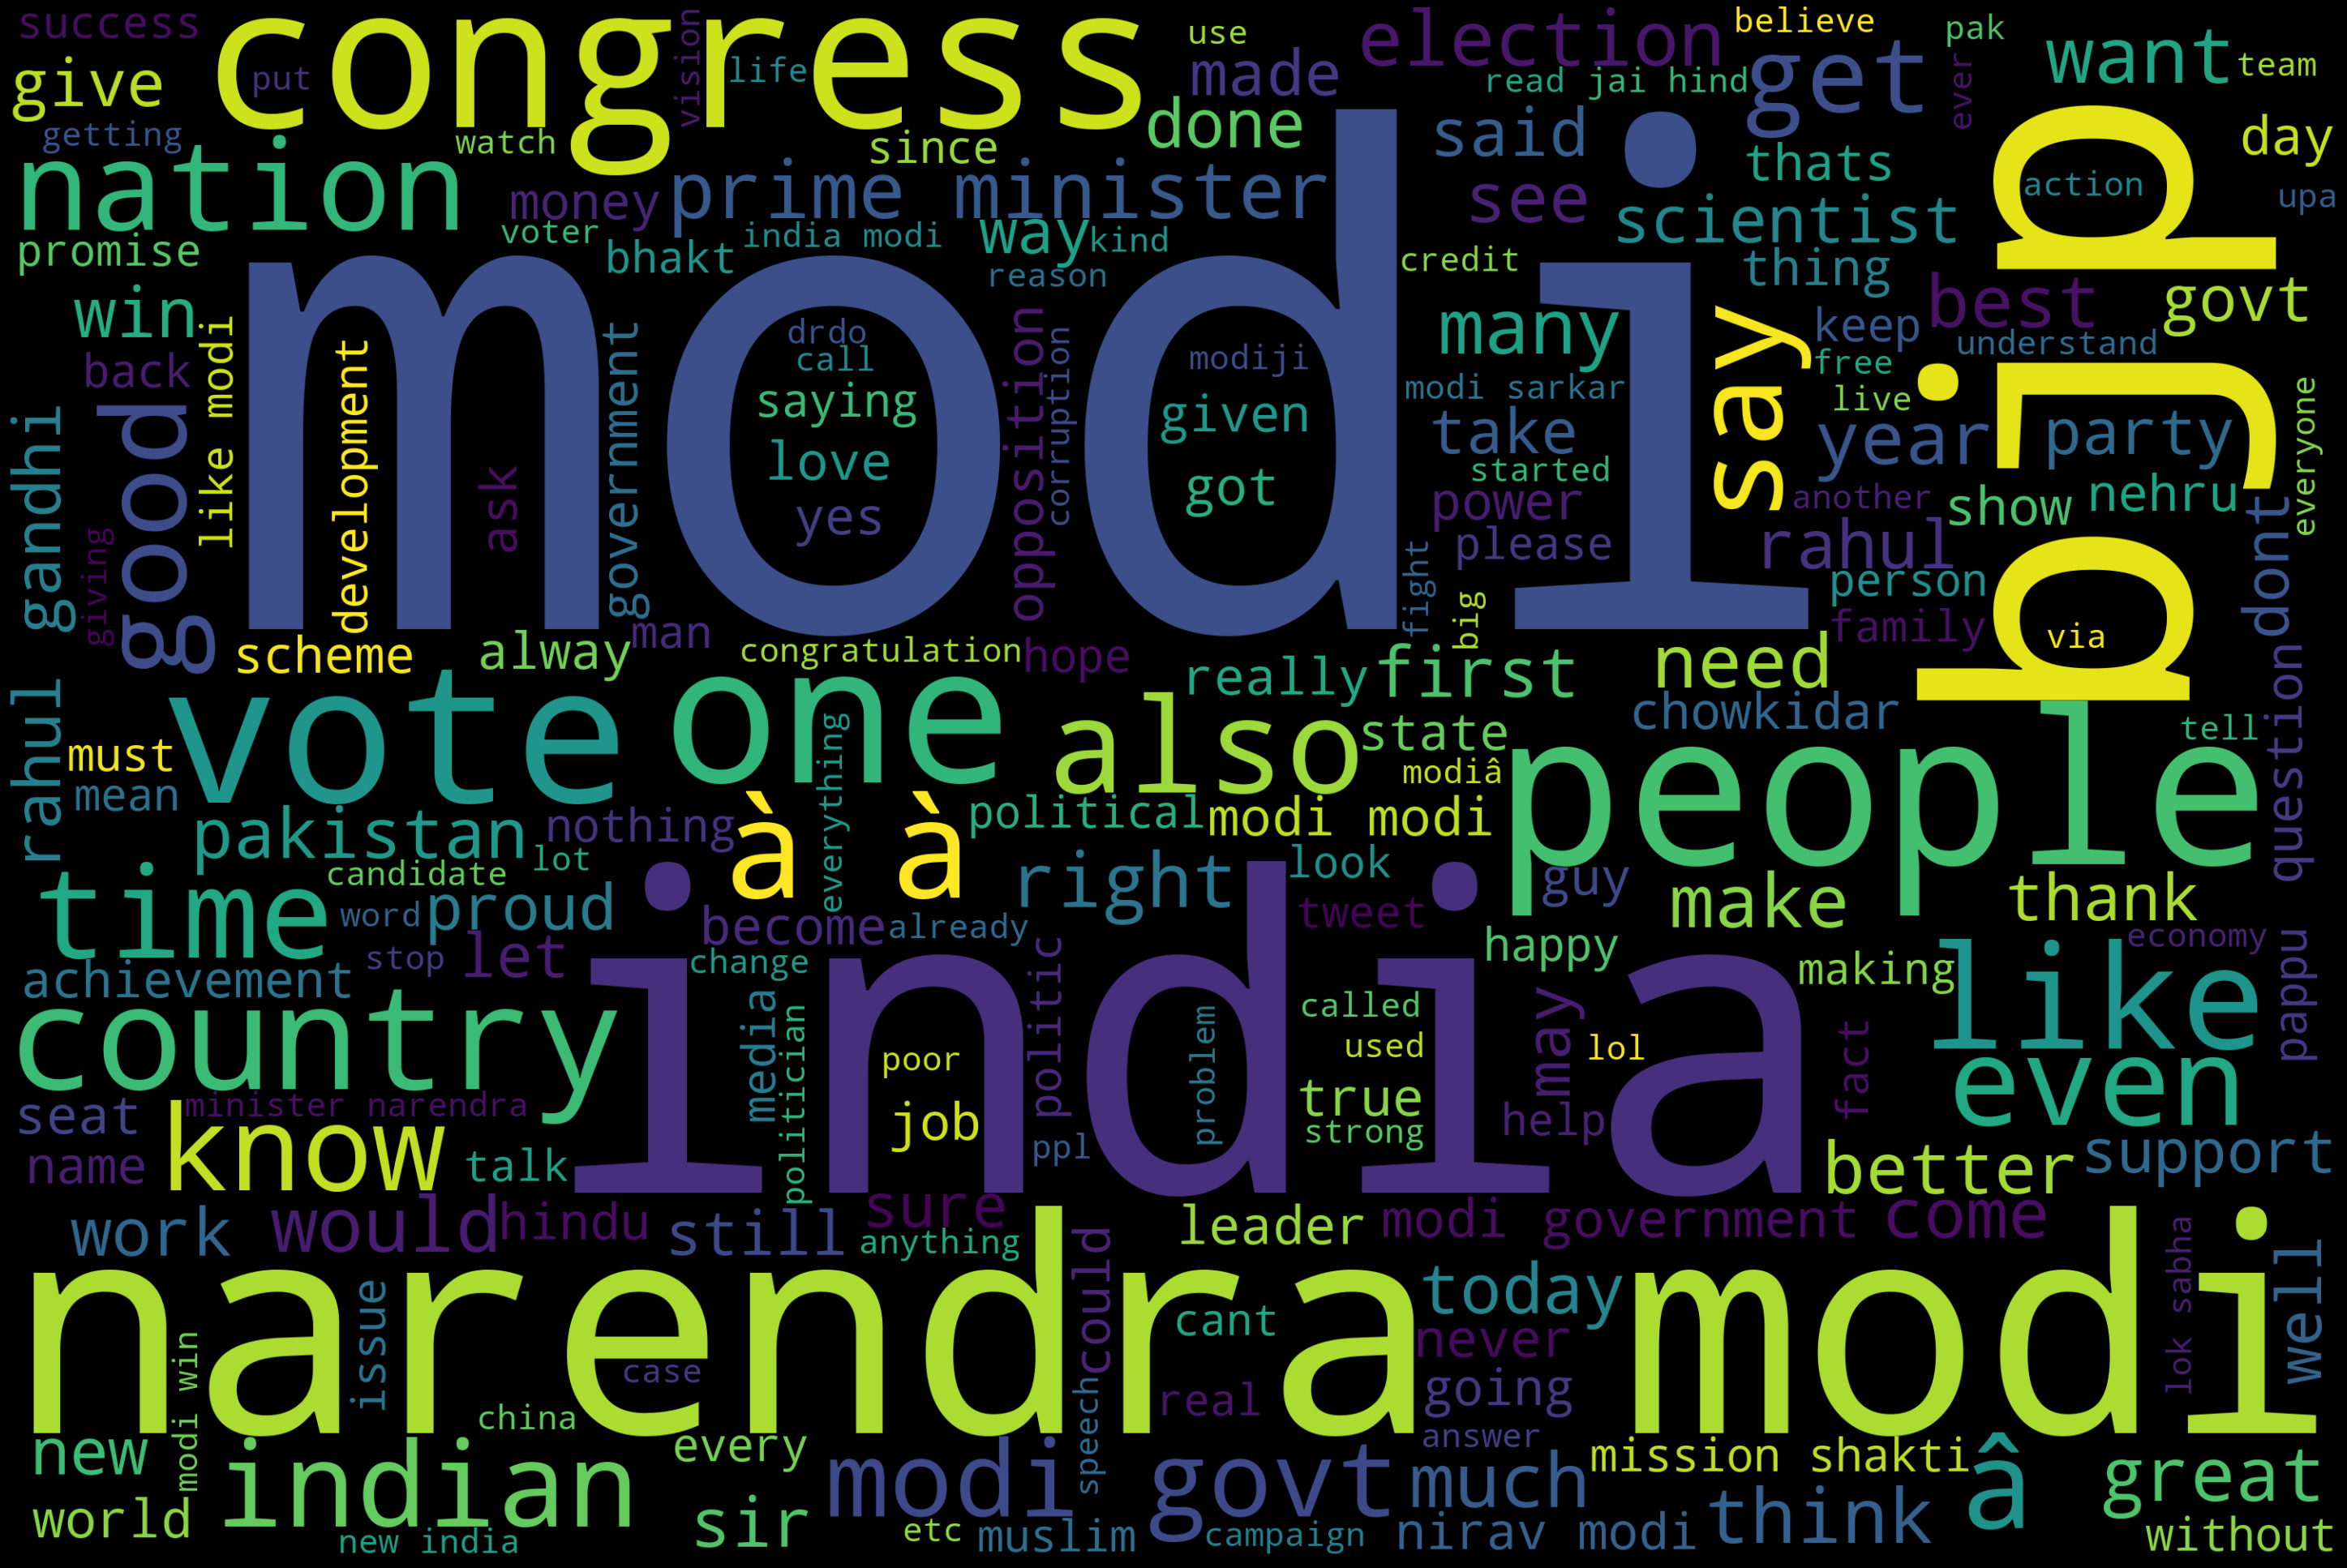

In [26]:
# positive tweets

text = ''

for tweet in df[df['category'] == 1.0]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

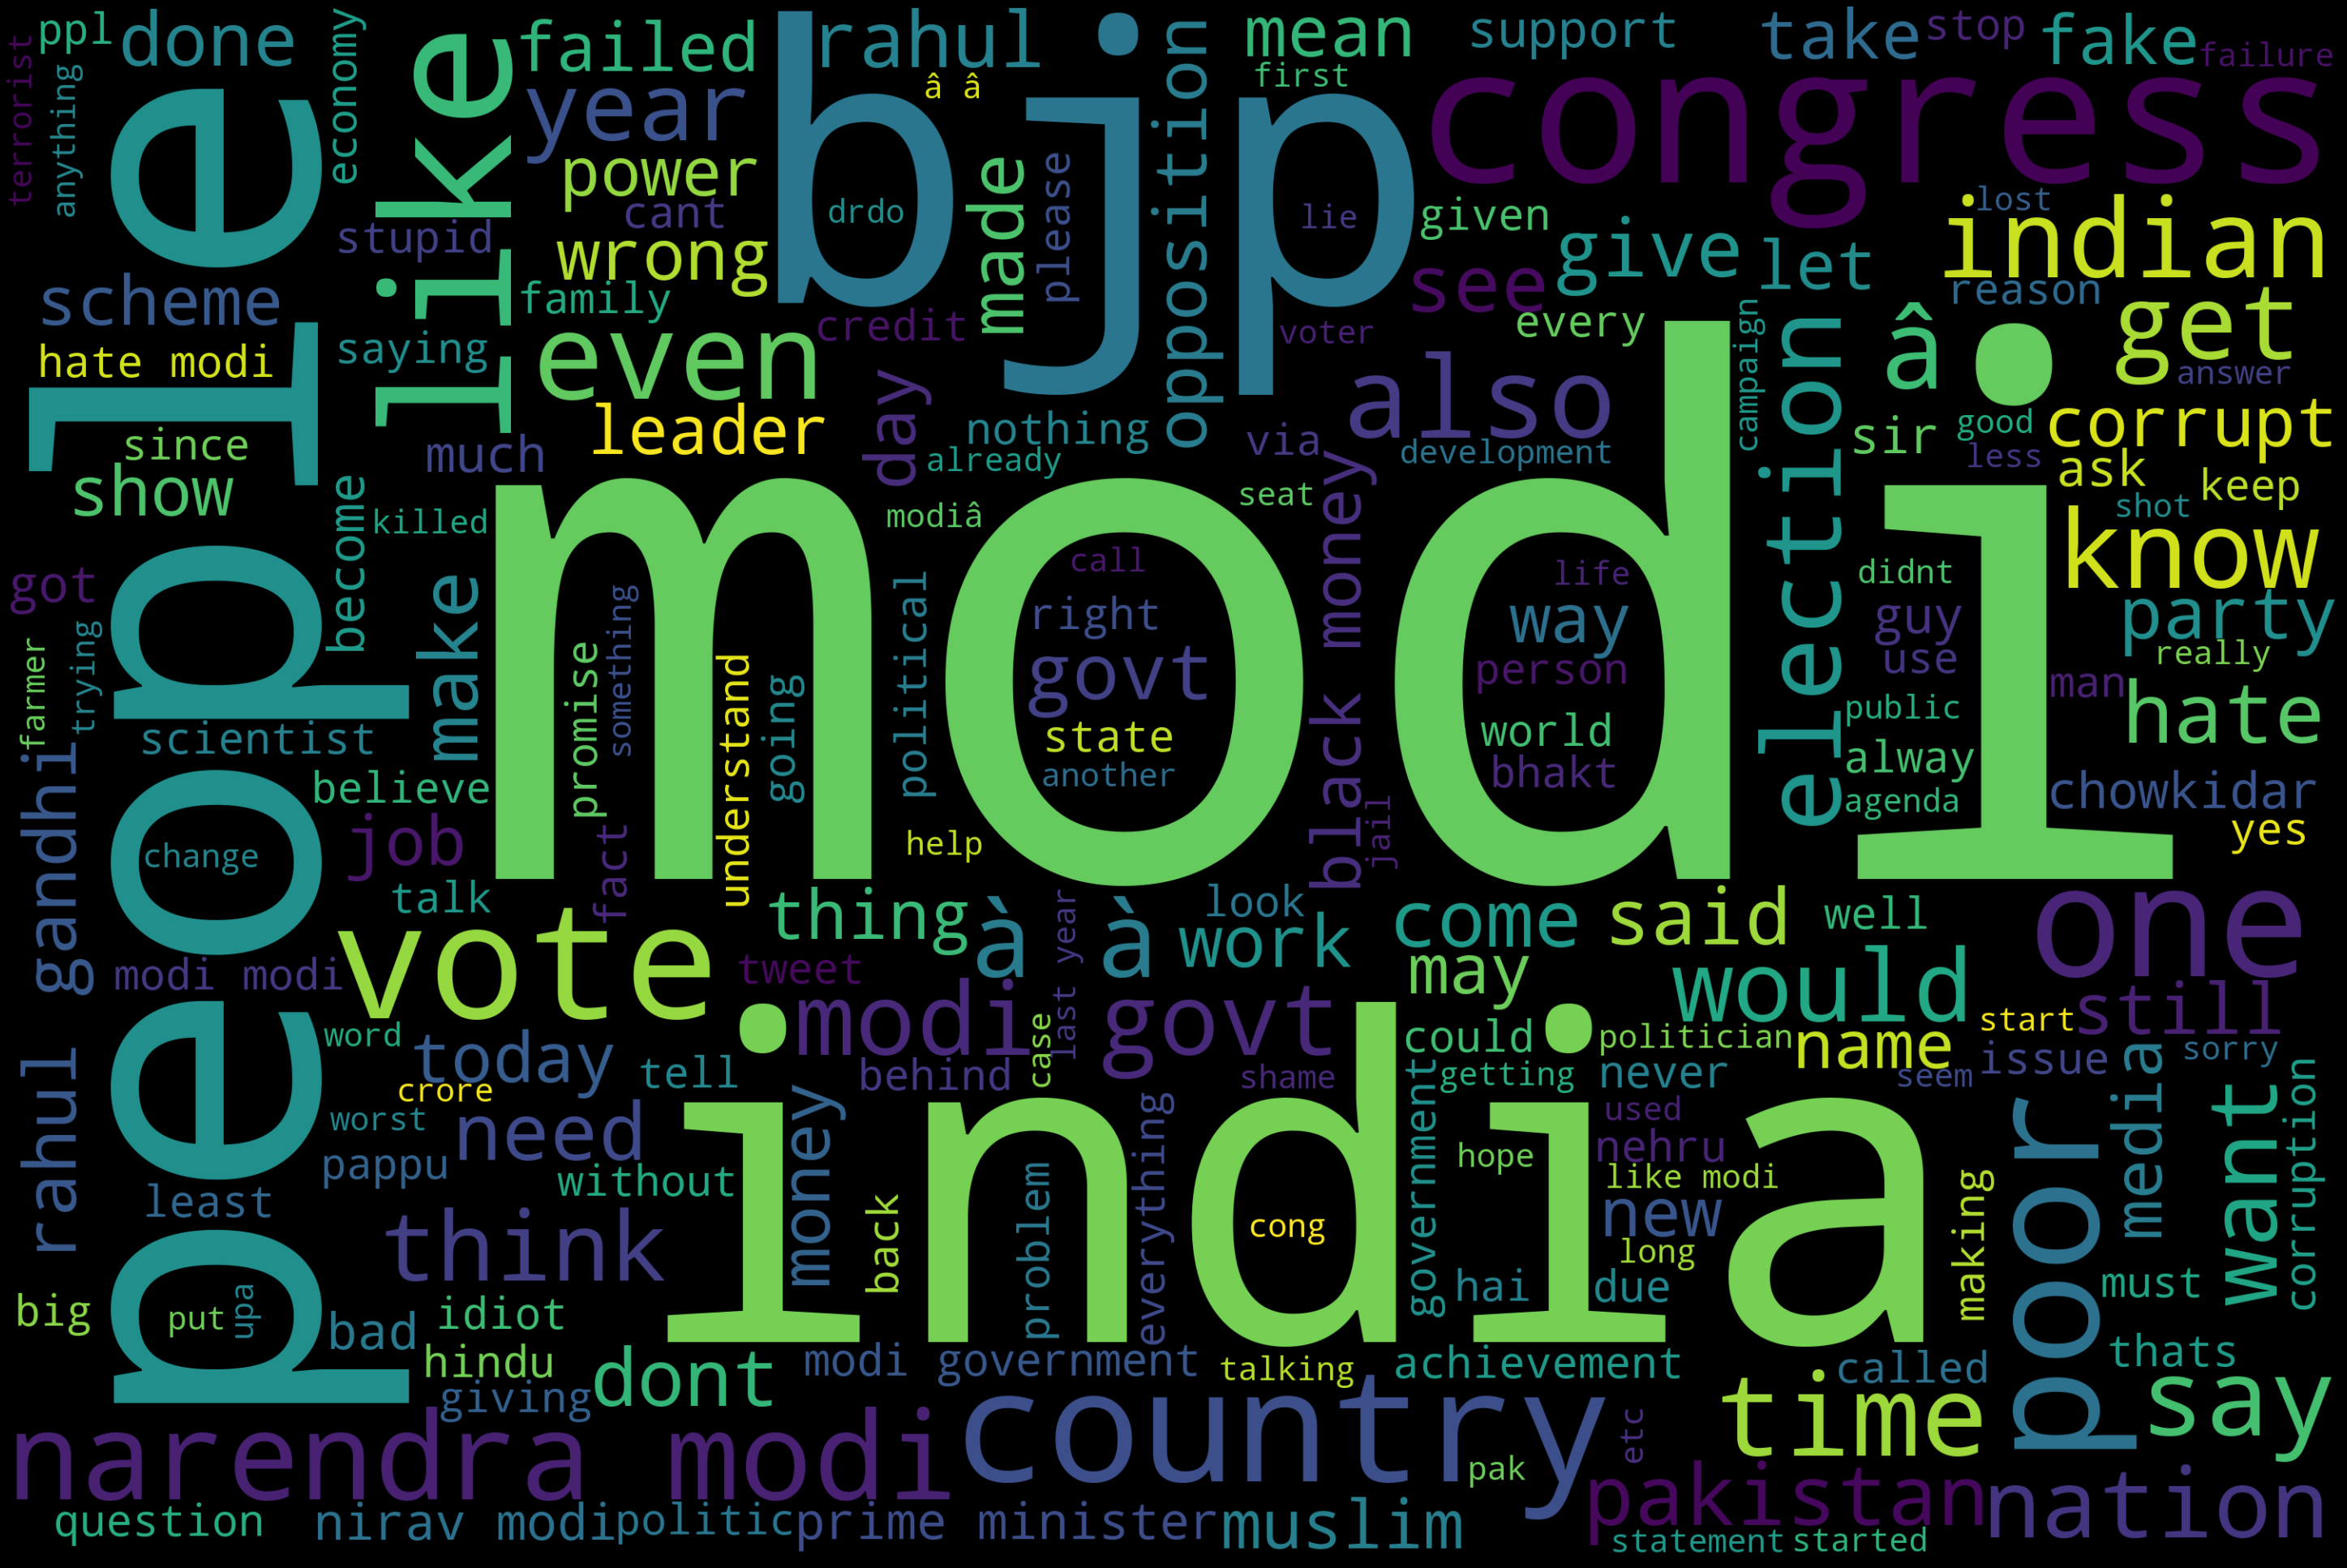

In [27]:
# negative tweets

text = ''

for tweet in df[df['category'] == -1.0 ]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

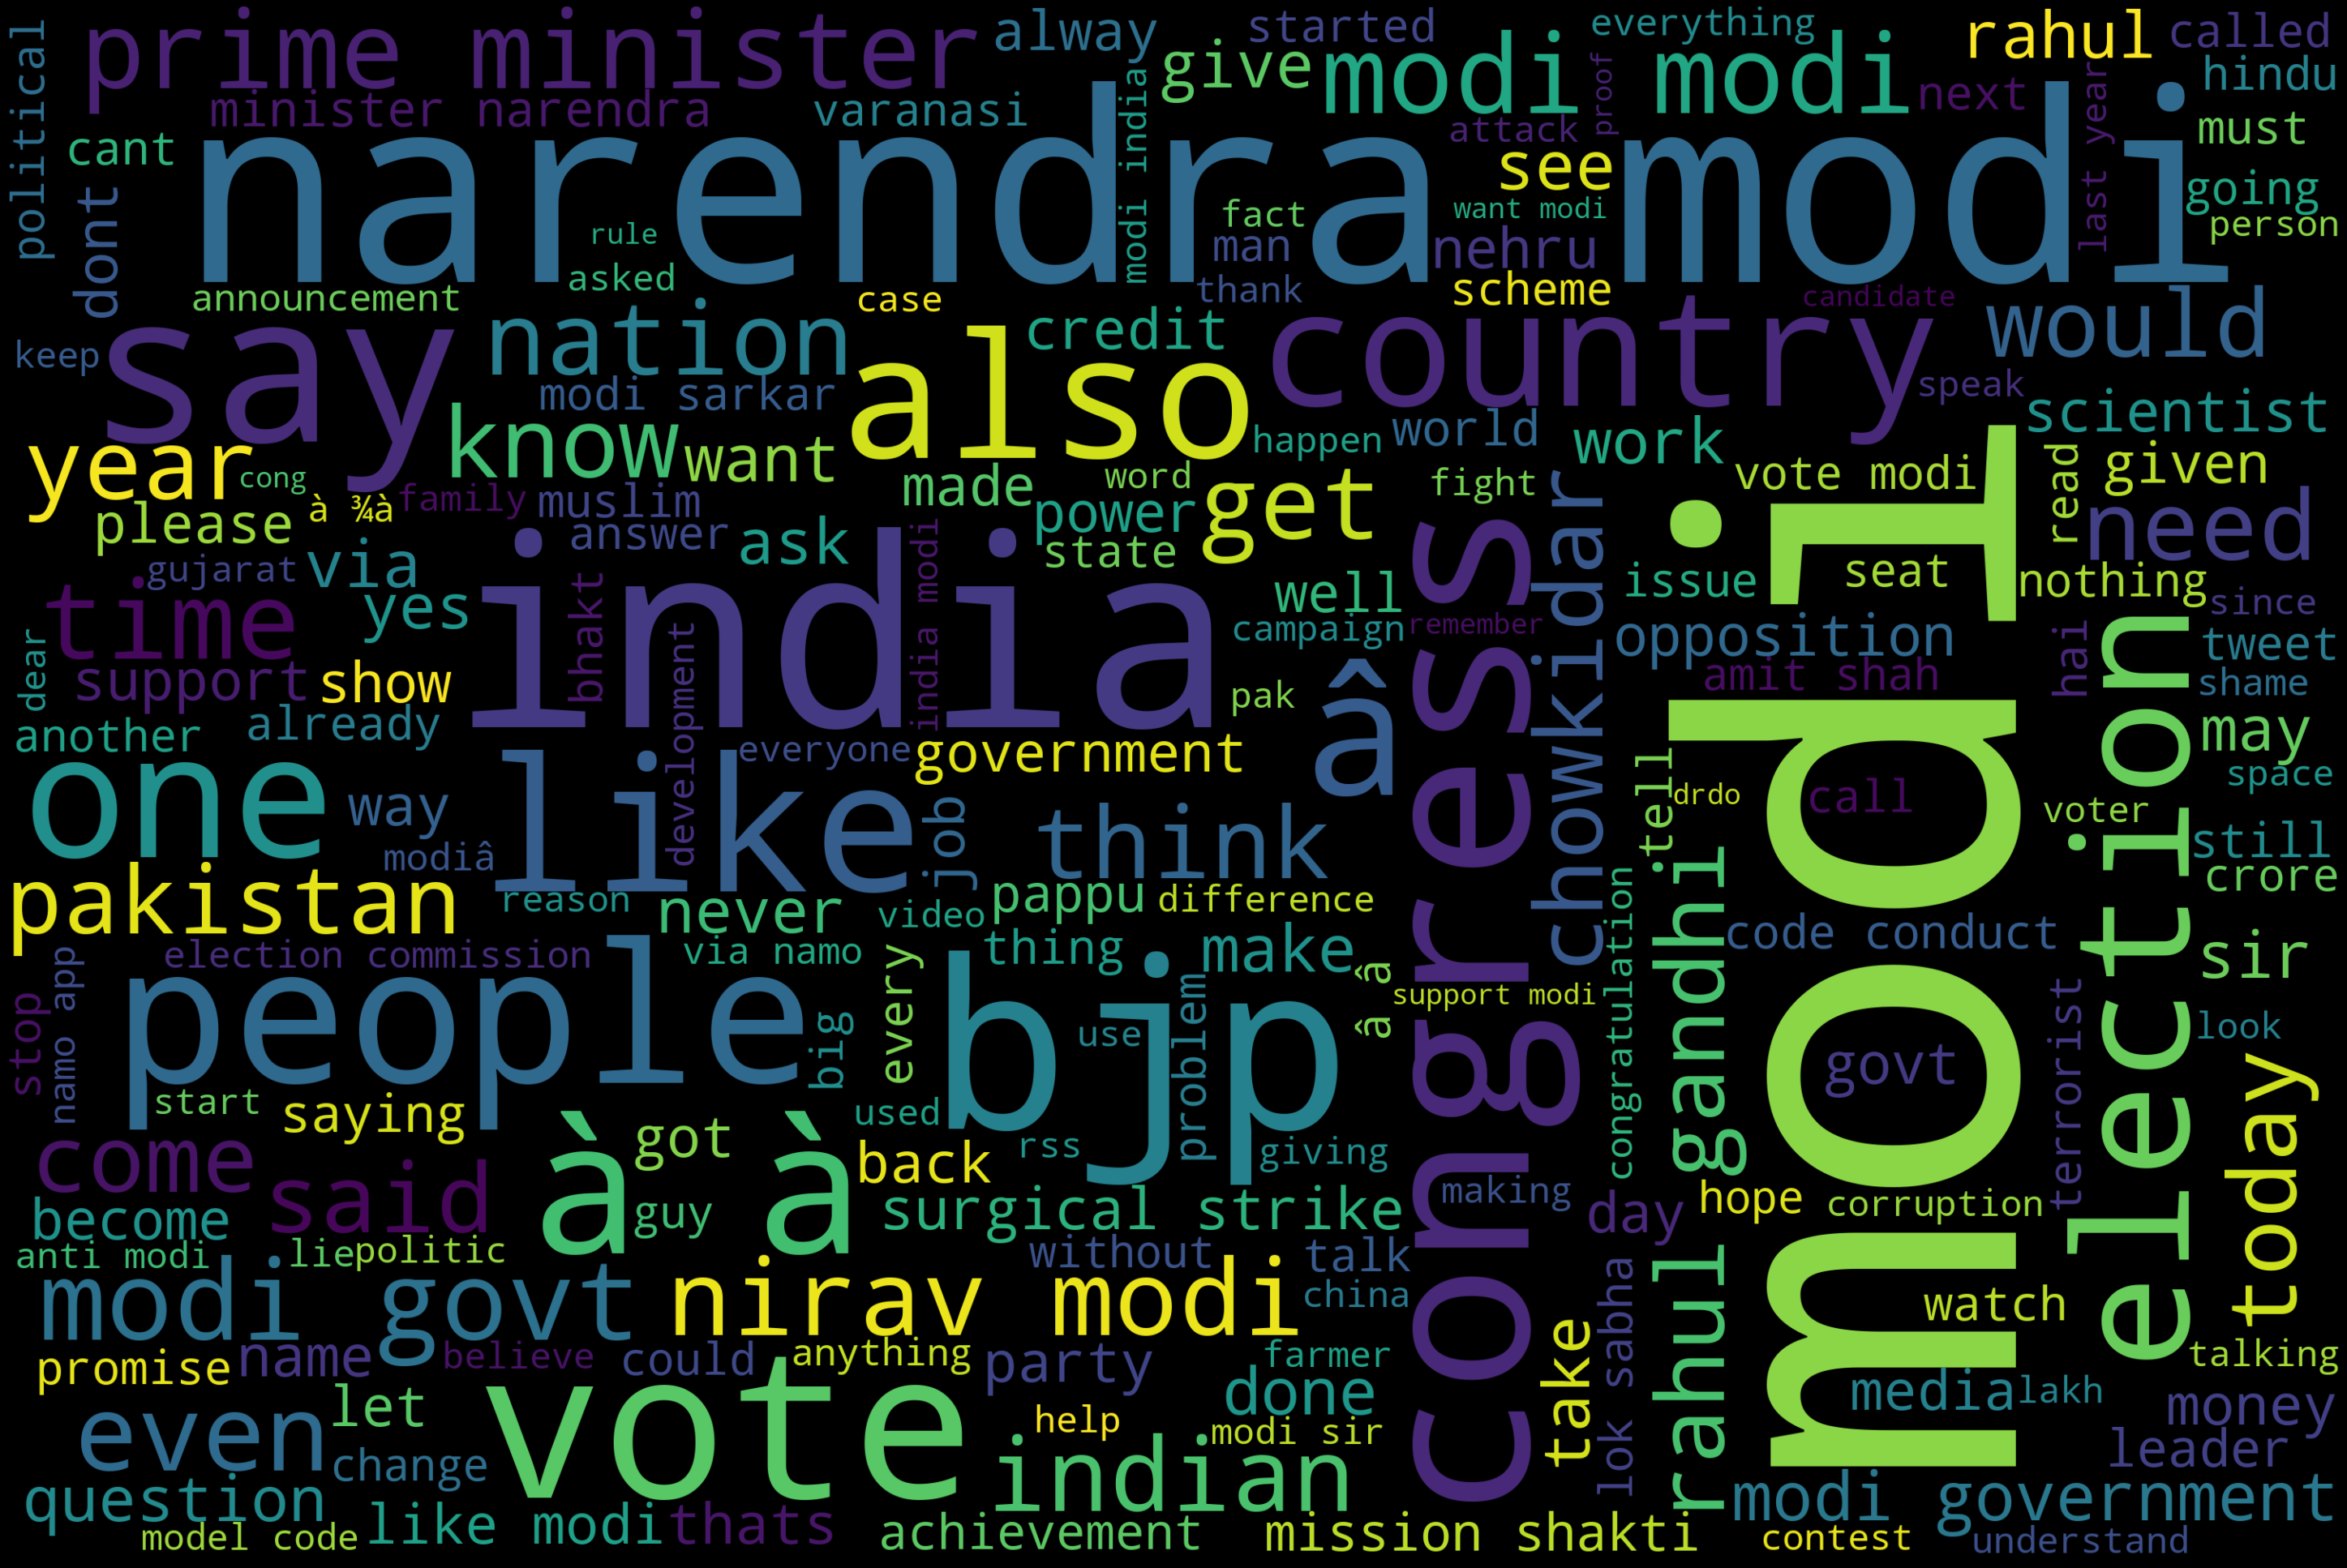

In [34]:
# positive tweets

text = ''

for tweet in df[df['category'] == 0.0 ]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

In [63]:
##count vectorizer
vec = CountVectorizer(max_features=10000)
vec.fit(df['clean_text'])

trn, val = train_test_split(df, test_size=0.3, random_state=42)

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [64]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.948947659078358

In [65]:
print(clf.score(val_abs, val['category']))

0.948947659078358


In [66]:
accuracy_score(val['category'], val_preds)

0.948947659078358

In [67]:
confusion_matrix(val['category'], val_preds)

array([[ 9572,   264,   855],
       [  198, 16215,   231],
       [  687,   261, 20608]], dtype=int64)

In [68]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.92      0.90      0.91     10691
         0.0       0.97      0.97      0.97     16644
         1.0       0.95      0.96      0.95     21556

    accuracy                           0.95     48891
   macro avg       0.94      0.94      0.94     48891
weighted avg       0.95      0.95      0.95     48891



In [69]:
##tf-idf vectorizer
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(df['clean_text']))

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [70]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

0.9446728436726596

In [71]:
print(clf.score(val_abs, val['category']))

0.9446728436726596


In [31]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
STOP_WORDS = stopwords.words("english")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [38]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        if type(sent) == type(''):
            example1 = BeautifulSoup(sent)
            sent = example1.get_text()
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in STOP_WORDS)
        sent=re.sub("[\d-]",'',sent)#remove digits
        porter=PorterStemmer()
        sent = ' '.join(porter.stem(e) for e in sent.split())
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [41]:
columns=df.columns.values
new_column_names=[]
for i in columns:
    s=i.split()
    d=[]
    for j in s:
        if j==':' or j=='.' or j=='(S)' or j=='(D)':
            pass
        else:
            d.append(j)
    final='_'.join(d)
    new_column_names.append(final)

In [43]:
df.columns=new_column_names

In [45]:
remove_dots=[]
for i in df.columns.values:
  remove_dots.append(i.strip('.'))


In [46]:
df.columns=remove_dots

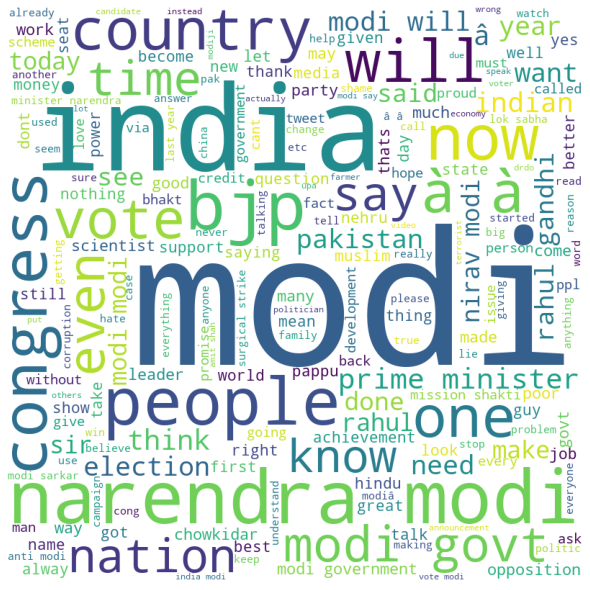

In [53]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from wordcloud import WordCloud, STOPWORDS
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the essay column  
for val in df['clean_text'].values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
  # plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [72]:
# tokenize
tok = Tokenizer(num_words = 1000000)
# fit
tok.fit_on_texts(df['clean_text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [73]:
X_trn = tok.texts_to_sequences(trn['clean_text'])
X_val = tok.texts_to_sequences(val['clean_text'])

In [75]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

In [76]:
embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(1, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           5683950   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
Fully_Connected (Dense)      (None, 200)               2000200   
_________________________________________________________________
Output (Dense)               (None, 1)                 201       
Total params: 7,684,351
Trainable params: 7,684,351
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit(X_trn, trn['category'], validation_data=(X_val, val['category']), verbose=True, epochs=20, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/20
446/446 [==============================] - 67s 147ms/step - loss: -32.4848 - accuracy: 0.5103 - val_loss: -160.0565 - val_accuracy: 0.5141
Epoch 2/20
446/446 [==============================] - 63s 140ms/step - loss: -866.8531 - accuracy: 0.5647 - val_loss: -1758.4175 - val_accuracy: 0.5837
Epoch 3/20
446/446 [==============================] - 64s 144ms/step - loss: -4147.2910 - accuracy: 0.5656 - val_loss: -5972.1982 - val_accuracy: 0.5702
Epoch 4/20
446/446 [==============================] - 62s 138ms/step - loss: -11052.1357 - accuracy: 0.5656 - val_loss: -13470.1494 - val_accuracy: 0.5669
Epoch 5/20
446/446 [==============================] - 64s 143ms/step - loss: -22296.1738 - accuracy: 0.5660 - val_loss: -24614.1719 - val_accuracy: 0.5381
Epoch 6/20
446/446 [==============================] - 65s 146ms/step - loss: -38399.5703 - accuracy: 0.5662 - val_loss: -39884.0039 - val_accuracy: 0.5409
Epoch 7/20
446/446 [==============================] - 63s 141ms/step - loss: -59

In [78]:
val_preds = model.predict(X_val)

f1_score(val['category'], val_preds, average='micro')

0.5499785236546604

In [79]:
##preformance matrics 
accuracy_score(val['category'], val_preds)

0.5499785236546604

In [80]:
confusion_matrix(val['category'], val_preds)

array([[    0, 10578,   113],
       [    0, 16618,    26],
       [    0, 11285, 10271]], dtype=int64)

In [81]:
print(classification_report(val['category'], val_preds))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00     10691
         0.0       0.43      1.00      0.60     16644
         1.0       0.99      0.48      0.64     21556

    accuracy                           0.55     48891
   macro avg       0.47      0.49      0.42     48891
weighted avg       0.58      0.55      0.49     48891



In [ ]:
###so this metrics states that there a lot of positive and neutral reviews and there are very less negative reviews 

<AxesSubplot:xlabel='category', ylabel='Density'>

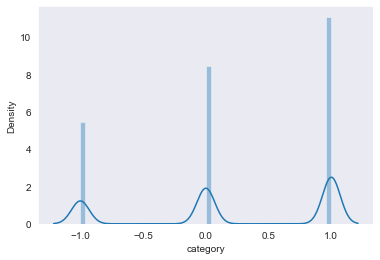

In [13]:
sns.distplot(df['category'])

<AxesSubplot:xlabel='category', ylabel='count'>

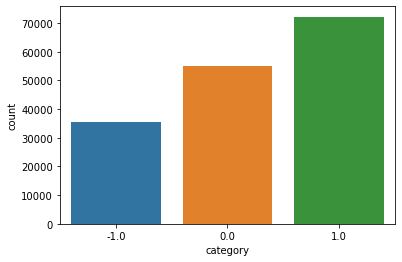

In [9]:
sns.countplot(df["category"])

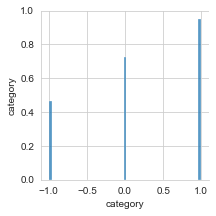

In [10]:
sns.set_style("whitegrid")
sns.pairplot(df[['clean_text','category']], size=3)
plt.show()

<AxesSubplot:>

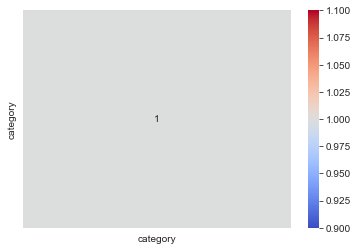

In [12]:
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')